In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from tqdm import tqdm

from flash_ansr import SkeletonPool, get_path
from flash_ansr.eval.metrics.bootstrap import bootstrapped_metric_ci

In [2]:
from sympy import simplify, parse_expr
from simplipy import SimpliPyEngine
from simplipy.utils import explicit_constant_placeholders, numbers_to_constant

In [3]:
MODEL = 'v23.0-3M'
ENGINE = 'dev_7-3'

In [4]:
pool = SkeletonPool.from_config(get_path('configs', MODEL, 'skeleton_pool_train.yaml'))
pool.simplify = False

engine = SimpliPyEngine.load('dev_7-3')

Compiling Skeletons: 100%|██████████| 107/107 [00:00<00:00, 19677.75it/s]


In [5]:
import multiprocessing as mp

def _simplify_worker(queue, expr_str, ratio):
    expr = parse_expr(expr_str)
    if ratio is not None:
        start_time = time.time()
        result = simplify(expr, ratio=ratio)
        end_time = time.time()
    else:
        start_time = time.time()
        result = simplify(expr)
        end_time = time.time()
    queue.put((result, end_time - start_time))

def run_simplify_with_timeout(expr_str, ratio=None, timeout_seconds=1):
    # Run sympy.simplify in a subprocess so we can kill long-running work cleanly in notebooks.
    queue = mp.Queue()
    proc = mp.Process(target=_simplify_worker, args=(queue, expr_str, ratio))
    proc.start()
    proc.join(timeout_seconds)
    if proc.is_alive():
        proc.terminate()
        proc.join()
        return None
    if queue.empty():
        return None
    return queue.get()

def sympy_simplify_wrapper(expression: list[str], ratio=None, debug=False):
    expression, constants = explicit_constant_placeholders(list(expression))
    if debug: print(expression)

    expression = engine.prefix_to_infix(expression, power='**')
    if debug: print(expression)

    for c in constants:
        expression = expression.replace(c, str(np.random.uniform(-10, 10)))
    if debug: print(expression)

    if debug: print('Simplifying in subprocess...')
    result = run_simplify_with_timeout(expression, ratio=ratio, timeout_seconds=1)
    if result is None:
        return None, None
    expression, elapsed_time = result
    expression = str(expression)
    if debug: print(expression)

    translations = {
        'Abs': 'abs',
    }

    for translate_from, translate_to in translations.items():
        expression = expression.replace(translate_from, translate_to)

    if debug: print(f'Parsing {expression}')
    expression = engine.parse(expression)
    if debug: print(expression)

    expression = numbers_to_constant(expression, inplace=True)
    if debug: print(expression)

    return tuple(expression), elapsed_time

In [6]:
sympy_simplify_wrapper(['+', 'x1', 'x1'], debug=True)

['+', 'x1', 'x1']
x1 + x1
x1 + x1
Simplifying in subprocess...
2*x1
Parsing 2*x1
['*', '2', 'x1']
['*', '<constant>', 'x1']


(('*', '<constant>', 'x1'), 0.05735135078430176)

In [ ]:
N_SAMPLES = 2**14
print(f'{N_SAMPLES:,}')

1,024


In [8]:
READ = False

In [9]:
if READ:
    with open(get_path('results', 'simplification', filename='simplification_results_simplipy.pkl'), 'rb') as f:
        simplification_results_simplipy = pickle.load(f)
else:
    simplification_results_simplipy = {}

    for max_pattern_length in range(1, 8):
        simplification_results_simplipy[f'simplipy_{max_pattern_length}'] = []

        pbar = tqdm(total=N_SAMPLES, smoothing=0)
        while len(simplification_results_simplipy[f'simplipy_{max_pattern_length}']) < N_SAMPLES:
            skeleton, _, _ = pool.sample_skeleton()

            pbar.set_postfix_str(f'{len(skeleton)}: {skeleton}')

            start_time = time.time()
            skeleton_simplified = engine.simplify(skeleton, max_pattern_length=max_pattern_length)
            end_time = time.time()

            simplification_results_simplipy[f'simplipy_{max_pattern_length}'].append({
                'original': skeleton,
                'simplified': skeleton_simplified,
                'time': end_time - start_time,
            })

            pbar.update(1)

        pbar.close()

    with open(get_path('results', 'simplification', filename='simplification_results_simplipy.pkl'), 'wb') as f:
        pickle.dump(simplification_results_simplipy, f)

100%|██████████| 1024/1024 [01:09<00:00, 14.76it/s, 29: ('-', '/', '-', 'x11', '*', 'x13', 'x13', '+', 'exp', '-', '+', 'x11', 'div2', 'inv', 'x13', 'x4', '+', '*', 'pow5', 'x3', '-', 'x11', 'x4', 'x15', '/', '*', 'x15', 'x3', 'x11')]                                                                                                


In [10]:
if READ:
    with open(get_path('results', 'simplification', filename='simplification_results_sympy.pkl'), 'rb') as f:
        simplification_results_sympy = pickle.load(f)
else:
    simplification_results_sympy = {}
    
    for ratio in [None, 1]:
        simplification_results_sympy[f'sympy_{ratio}'] = []

        pbar = tqdm(total=N_SAMPLES, smoothing=0)
        while len(simplification_results_sympy[f'sympy_{ratio}']) < N_SAMPLES:
            skeleton, _, _ = pool.sample_skeleton()

            pbar.set_postfix_str(f'{len(skeleton)}: {skeleton}')

            sympy_simplified, elapsed_time = sympy_simplify_wrapper(skeleton, ratio=ratio)

            simplification_results_sympy[f'sympy_{ratio}'].append({
                'original': skeleton,
                'simplified': sympy_simplified,
                'time': elapsed_time,
            })

            pbar.update(1)

        pbar.close()

    with open(get_path('results', 'simplification', filename='simplification_results_sympy.pkl'), 'wb') as f:
        pickle.dump(simplification_results_sympy, f)

100%|██████████| 1024/1024 [05:13<00:00,  3.27it/s, 27: ('-', 'x8', '-', 'sinh', 'mult3', 'exp', '/', '*', '*', 'x14', 'x11', 'acos', 'x11', 'x15', '/', 'x15', '/', 'acos', 'x14', '-', 'x3', 'mult5', 'cos', '+', 'x8', 'atan', 'x15')]                                                          


In [11]:
# merge the two results
results = simplification_results_simplipy | simplification_results_sympy
results.keys()

dict_keys(['simplipy_1', 'simplipy_2', 'simplipy_3', 'simplipy_4', 'simplipy_5', 'simplipy_6', 'simplipy_7', 'sympy_None', 'sympy_1'])

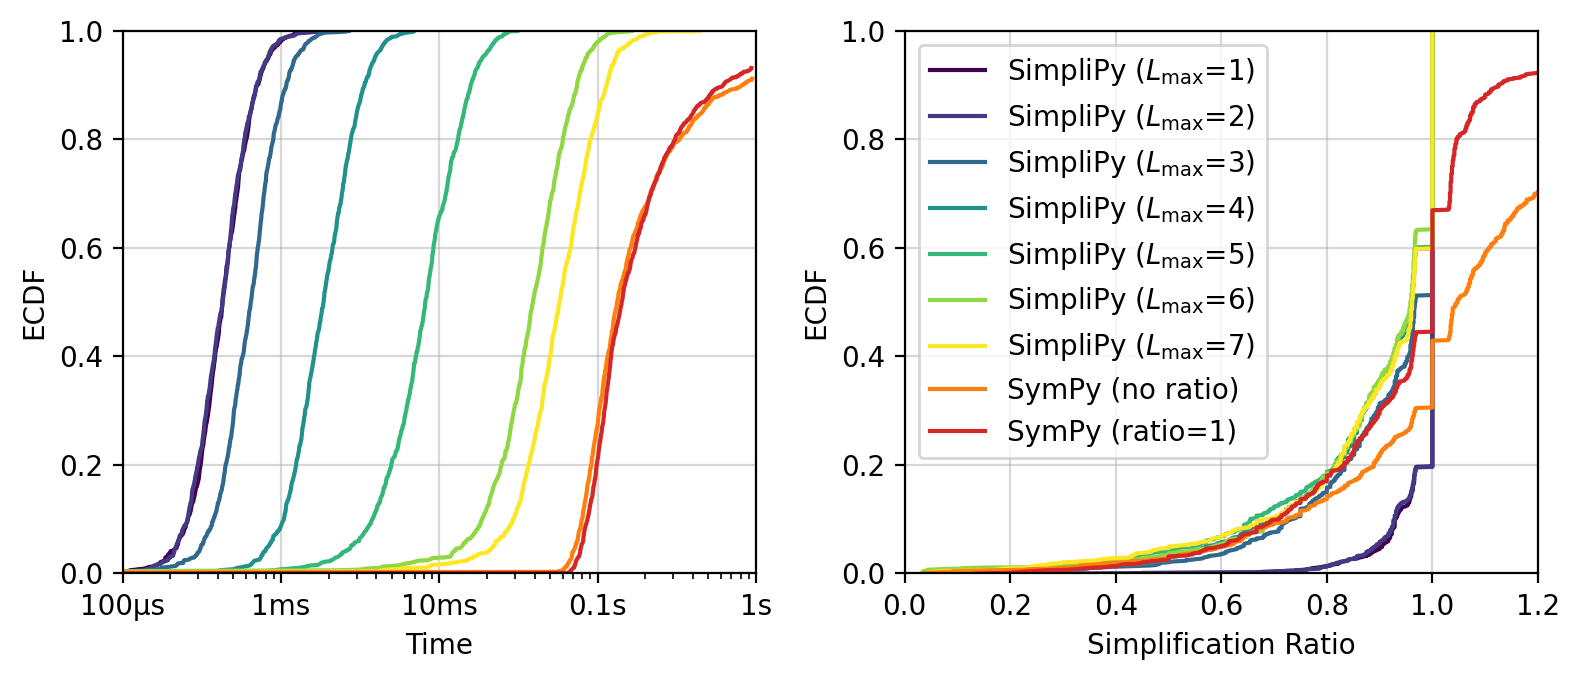

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), dpi=200)

colors_simplipy = plt.cm.viridis(np.linspace(0, 1, 7))
colors_sympy = ['tab:orange', 'tab:red']

all_colors = {
    'simplipy_1': colors_simplipy[0],
    'simplipy_2': colors_simplipy[1],
    'simplipy_3': colors_simplipy[2],
    'simplipy_4': colors_simplipy[3],
    'simplipy_5': colors_simplipy[4],
    'simplipy_6': colors_simplipy[5],
    'simplipy_7': colors_simplipy[6],
    'sympy_None': colors_sympy[0],
    'sympy_1': colors_sympy[1],
}

legend_labels = {
    'simplipy_1': 'SimpliPy ($L_\\text{max}$=1)',
    'simplipy_2': 'SimpliPy ($L_\\text{max}$=2)',
    'simplipy_3': 'SimpliPy ($L_\\text{max}$=3)',
    'simplipy_4': 'SimpliPy ($L_\\text{max}$=4)',
    'simplipy_5': 'SimpliPy ($L_\\text{max}$=5)',
    'simplipy_6': 'SimpliPy ($L_\\text{max}$=6)',
    'simplipy_7': 'SimpliPy ($L_\\text{max}$=7)',
    'sympy_None': 'SymPy (no ratio)',
    'sympy_1': 'SymPy (ratio=1)',
}

for method, method_results in results.items():
    times = [r['time'] for r in method_results]
    # Replace None with infinity for plotting
    times = [t if t is not None else float('inf') for t in times]
    axes[0].plot(
        np.sort(times),
        np.linspace(0, 1, len(times)),
        label=method,
        color=all_colors[method],
    )

    axes[0].set_xscale('log')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('ECDF')
    # axes[0].legend()
    axes[0].set_xlim(1e-4, 1)
    axes[0].set_ylim(0, 1)
    axes[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
    axes[0].get_xaxis().set_major_formatter(plt.ScalarFormatter())
    axes[0].set_xticklabels(['100µs', '1ms', '10ms', '0.1s', '1s'])
    axes[0].grid(alpha=0.5)


for method, method_results in results.items():
    original_lengths = [len(r['original']) if r['original'] is not None else float('inf') for r in method_results]
    simplified_lengths = [len(r['simplified']) if r['simplified'] is not None else float('inf') for r in method_results]
    ratios = [
        simplified / original if original > 0 else float('inf')
        for original, simplified in zip(original_lengths, simplified_lengths)
    ]
    # deltas = [
    #     simplified - original
    #     for original, simplified in zip(original_lengths, simplified_lengths)
    # ]
    axes[1].plot(
        np.sort(ratios),
        np.linspace(0, 1, len(ratios)),
        label=legend_labels[method],
        color=all_colors[method],
    )

    # axes[1].set_yscale('log')
    axes[1].set_xlabel('Simplification Ratio')
    axes[1].set_ylabel('ECDF')
    axes[1].legend()
    axes[1].set_xlim(0, 1.2)
    axes[1].set_ylim(1e-3, 1)
    axes[1].grid(alpha=0.5)

axes[1].set_ylim(0, 1)

fig.tight_layout()